In [7]:
from __future__ import division
from __future__ import print_function

import time
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from utils import load_data, test, train, accuracy, run_experiment
from layers import GraphConvolution

adj, features, labels = load_data(path="../data/cora/", dataset="cora")
idx_train = range(140)
idx_val = range(200, 500)
idx_test = range(500, 1500)
idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

hidden = 16
dropout = 0.5
lr = 0.01
weight_decay = 5e-4
num_epochs = 200
smooth_fac = 0.5

Loading cora dataset...


In [8]:
class ite_GCN_try1(nn.Module):
    def __init__(self, num_feat, num_class, dropout, latent_dim,train_nite, eval_nite=0, allow_grad=True, smooth_fac=0):
        '''     
        - The current architecture of the model is:
            - Encoder:      encode features into the latent space
            - GC:           iterations in the latent space
            - Decoder:      decode to the output space
        - Activation: ReLu
        - Input:
            - num_feat:        the number of features of each node
            - num_class:       the number of target classes (we are doing a node classification task here)
            - dropout:      dropout rate
            - latent_dim:   the dimension of the latent space
            - train_nite:   the number of iterations during training
            - eval_nite:    the number of iterations during evaluation, 
                            if not specified (or invalid), intialize to the same as train_nite
            - allow_grad:   (bool) defaulted to True. 
                            whether or nor allow gradients to flow through all GC iterations, 
                            if False, gradients will only flow to the last iteration
            - smooth_fac:   a number in [0,1], smoothing factor, controls how much of the OLD iteration result is
                            counted in the skip connection in each iteration
                            for example, smooth_fac = x means y_{i+1} = x * y_i + (1-x) * y_{i+1}
                            Invalid inputs will be treated as 0.
        - Output:
            - A probability vector of length nclass, by log_softmax
        '''
        super(ite_GCN_try1, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(1433, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU()
        )
        
        self.gc = GraphConvolution(32, 32)
        self.decoder = nn.Linear(32, num_class, bias=False)
        
        self.dropout = dropout
        self.train_nite = train_nite
        self.allow_grad = allow_grad
        self.smooth_fac = smooth_fac
        self.eval_nite = eval_nite
        
        if (smooth_fac > 1) or (smooth_fac < 0):
            print("Invalid smoothing factor. Treat as 0.")
            self.smooth_fac = 0
        if (eval_nite <= 0):
            print("Unspecified or invalid number of iterations for inference. Treat as the same as training iterations.")
            self.eval_nite = self.train_nite
        
        print("Initialize a 1-layer GCN with ", self.train_nite, "iterations")
        print("Gradient flows to all iterations: ", allow_grad)

    def run_one_layer(self, x, adj):
        x_old = x
        x_new = self.gc(x, adj)
        x = F.relu(self.smooth_fac * x_old + (1 - self.smooth_fac) * x_new)
        x = F.dropout(x, self.dropout, training=self.training)
        return x

    def forward(self, x, adj):
        x = self.encoder(x)
        x = F.dropout(x, self.dropout, training=self.training)

        if self.training:
            for i in range(self.train_nite):
                if not self.allow_grad:
                    x = x.detach()
                    x = self.run_one_layer(x, adj)
                else:
                    x = self.run_one_layer(x, adj)
        else:
            for i in range(self.eval_nite):
                x = self.run_one_layer(x, adj)

        x = self.decoder(x)
        return F.log_softmax(x, dim=1)
        

Unspecified or invalid number of iterations for inference. Treat as the same as training iterations.
Initialize a 1-layer GCN with  3 iterations
Gradient flows to all iterations:  True
runrunrun!
Epoch: 0001 loss_train: 1.9469 acc_train: 0.1143 loss_val: 1.9408 acc_val: 0.0833 time: 0.0913s
Epoch: 0002 loss_train: 1.9409 acc_train: 0.1429 loss_val: 1.9343 acc_val: 0.3500 time: 0.0984s
Epoch: 0003 loss_train: 1.9429 acc_train: 0.1429 loss_val: 1.9289 acc_val: 0.3500 time: 0.1007s
Epoch: 0004 loss_train: 1.9387 acc_train: 0.1571 loss_val: 1.9237 acc_val: 0.3500 time: 0.0517s
Epoch: 0005 loss_train: 1.9215 acc_train: 0.2500 loss_val: 1.9178 acc_val: 0.3500 time: 0.0495s
Epoch: 0006 loss_train: 1.9156 acc_train: 0.2786 loss_val: 1.9092 acc_val: 0.3500 time: 0.0513s
Epoch: 0007 loss_train: 1.9166 acc_train: 0.2214 loss_val: 1.8962 acc_val: 0.3500 time: 0.0481s
Epoch: 0008 loss_train: 1.8997 acc_train: 0.1857 loss_val: 1.8744 acc_val: 0.3500 time: 0.0698s
Epoch: 0009 loss_train: 1.8872 acc_t

(tensor(3.5013, grad_fn=<NllLossBackward0>),
 tensor(0.4090, dtype=torch.float64),
 9.876941680908203)

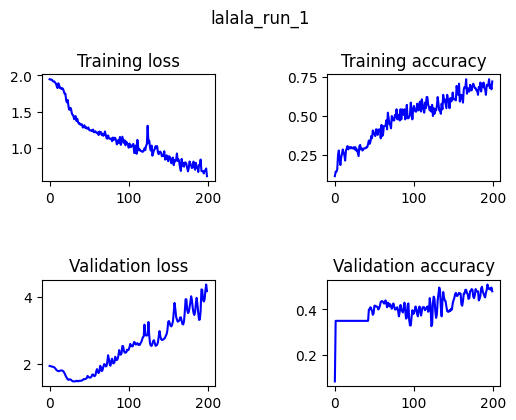

In [13]:
lr = 0.007
weight_decay = 1e-4
model = ite_GCN_try1(num_feat=1433,
            num_class=labels.max().item() + 1,
            dropout=dropout,
            latent_dim= 16,
            train_nite= 3,
            eval_nite= 0,
            allow_grad=True,
            smooth_fac=0.5)
run_experiment(num_epochs=num_epochs, model=model, lr=lr, weight_decay=weight_decay, features=features, adj=adj, idx_train=idx_train, idx_val=idx_val, idx_test=idx_test, labels=labels, model_name="lalala", run=1)

In [10]:
class GCN_2(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN_2, self).__init__()
        '''
        added by Sizhuang: 
            
        - This model is a 2-layer GCN.
            - First layer:    nfeat to nhid
            - Final layer:    nhid to nclass
        - Activation: ReLu
        - Input:
            - nfeat: the number of features of each node
            - nhid: the dimension of the hidden representation for each node
            - nclass: the number of target classes (we are doing a node classification task here)
            - dropout: dropout rate
        - Output:
            - A probability vector of length nclass, by log_softmax
        '''

        print("Intialize a 2-layer GCN")
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(1433, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU()
        )
        self.gc1 = GraphConvolution(nhid, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        # x: input data matrix
        # adj: adjacency matrix
        x = self.encoder(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj) 
        return F.log_softmax(x, dim=1)

Intialize a 2-layer GCN
runrunrun!
Epoch: 0001 loss_train: 1.9557 acc_train: 0.1000 loss_val: 1.9612 acc_val: 0.1033 time: 0.1168s
Epoch: 0002 loss_train: 1.9440 acc_train: 0.1000 loss_val: 1.9490 acc_val: 0.1033 time: 0.0379s
Epoch: 0003 loss_train: 1.9341 acc_train: 0.1000 loss_val: 1.9387 acc_val: 0.1033 time: 0.0423s
Epoch: 0004 loss_train: 1.9148 acc_train: 0.1000 loss_val: 1.9280 acc_val: 0.1033 time: 0.0478s
Epoch: 0005 loss_train: 1.9125 acc_train: 0.0857 loss_val: 1.9163 acc_val: 0.1033 time: 0.0498s
Epoch: 0006 loss_train: 1.9035 acc_train: 0.1214 loss_val: 1.9028 acc_val: 0.1100 time: 0.0398s
Epoch: 0007 loss_train: 1.9056 acc_train: 0.1429 loss_val: 1.8892 acc_val: 0.1567 time: 0.0449s
Epoch: 0008 loss_train: 1.8898 acc_train: 0.2071 loss_val: 1.8709 acc_val: 0.3467 time: 0.0364s
Epoch: 0009 loss_train: 1.8635 acc_train: 0.2643 loss_val: 1.8490 acc_val: 0.3500 time: 0.0348s
Epoch: 0010 loss_train: 1.8356 acc_train: 0.2714 loss_val: 1.8223 acc_val: 0.3500 time: 0.0392s
Epoch

(tensor(6.2367, grad_fn=<NllLossBackward0>),
 tensor(0.4310, dtype=torch.float64),
 10.152660131454468)

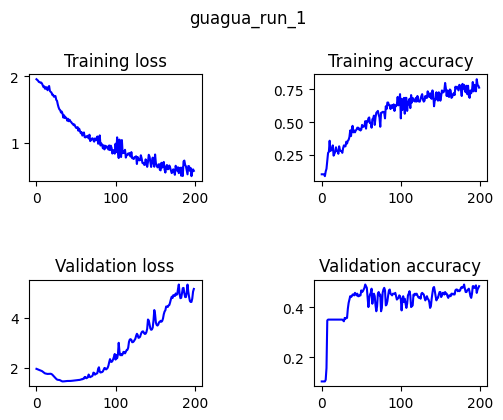

In [11]:
model0 = GCN_2(nfeat=features.shape[1],
            nhid=hidden,
            nclass=labels.max().item() + 1,
            dropout=dropout
)
run_experiment(num_epochs=num_epochs, model=model0, lr=lr, weight_decay=weight_decay, features=features, adj=adj, idx_train=idx_train, idx_val=idx_val, idx_test=idx_test, labels=labels, model_name="guagua", run=1)
